## Run the inference with the PyTorch model

In [1]:
import torch
import lightglue_dynamo.models.superpoint_pytorch as superpoint_pytorch

detection_thresh = 0.005
nms_radius = 5
max_keypoints = 256

sp_th = superpoint_pytorch.SuperPointOpen(detection_threshold=detection_thresh, nms_radius=nms_radius, max_num_keypoints=max_keypoints).eval()
print('Config:', sp_th.conf)

# Load state dict (map_location="cpu" if no GPU)
ckpt = torch.load("/home/nvidia/third_party/LightGlue-ONNX-Jetson/weights/superpoint_v6_from_tf.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")

# Some checkpoints may be wrapped in {"state_dict": ...}
if "state_dict" in ckpt:
    ckpt = ckpt["state_dict"]

# Load weights
sp_th.load_state_dict(ckpt, strict=True)
sp_th.eval().cuda()
# sp_th = torch.compile(sp_th, mode="reduce-overhead")  # "max-autotune" , "reduce-overhead"

/home/nvidia/third_party/LightGlue-ONNX-Jetson/.venv/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/nvidia/third_party/LightGlue-ONNX-Jetson/.venv/lib/python3.10/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Config: namespace(nms_radius=5, max_num_keypoints=256, detection_threshold=0.005, remove_borders=4, descriptor_dim=256, channels=[64, 64, 128, 128, 256])


/tmp/ipykernel_20775/1623159141.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/home/nvidia/third_party/LightGlue-ONNX-Jetson/weights/superpoint_v6_

SuperPointOpen(
  (backbone): Sequential(
    (0): Sequential(
      (0): VGGBlock(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): VGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): VGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): VGGBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [2]:
import torch, cv2, numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale)
image_path = '/home/nvidia/third_party/LightGlue-ONNX-Jetson/assets/debug1.png'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # [H,W]
img = img.astype(np.float32) / 255.0

# Pad image so that H,W are divisible by 8 (SuperPoint stride requirement)
H, W = img.shape
pad_h = int(np.ceil(H / 8) * 8 - H)
pad_w = int(np.ceil(W / 8) * 8 - W)
img = np.pad(img, ((0, pad_h), (0, pad_w)))

# Convert to tensor [B,1,H,W] and send to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor = torch.from_numpy(img)[None, None].to(device)  # shape [1,1,H,W]

In [3]:
with torch.no_grad():
    pred = sp_th({"image": tensor})

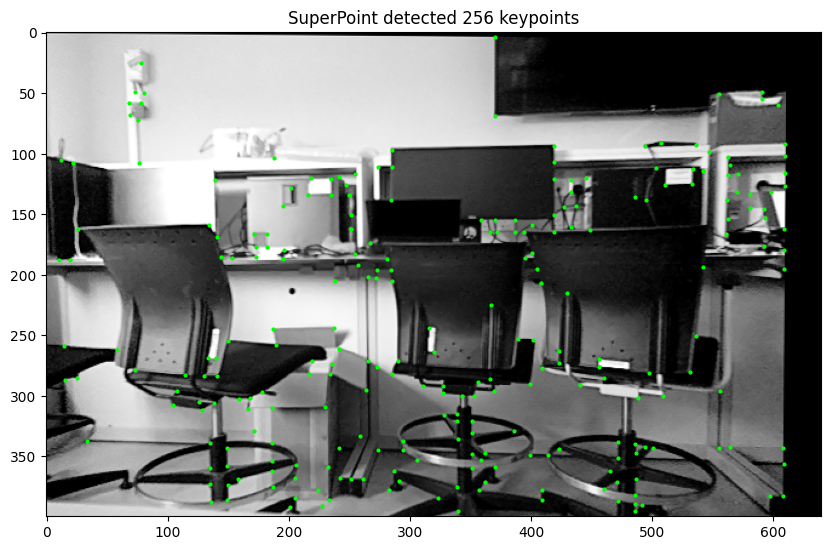

In [4]:
kpts = pred["keypoints"][0].cpu().numpy()       # (N,2)
scores = pred["keypoint_scores"][0].cpu().numpy()

plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')
plt.scatter(kpts[:,0], kpts[:,1], s=4, c='lime')
plt.title(f"SuperPoint detected {len(kpts)} keypoints")
plt.show()

In [ ]:
for k, v in pred.items():
    print(f"{k}: {[t.cpu().shape for t in v]}")


keypoints: [torch.Size([256, 2])]
keypoint_scores: [torch.Size([256])]
descriptors: [torch.Size([256, 256])]
